## DESI Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,8)
fontsize = 18

temp_output_loc = '/global/homes/j/jfarr/Projects/QuasarNET_DESI/'

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## General parameters
selections = ['SV0_QSO','MINI_SV_QSO']
expids = ['00055626','00055627','00055628']

## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.47
include_p_sq = True

In [4]:
f_truth = qnet_path+'/data/MiniSV/SV0/SV0_truth_tile68002_night20200315.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

selection = 'SV0_QSO'
for expid in expids:

    ## Load the RR data.
    f_rr = temp_output_loc+'/rr_results/rr_SV0_{}.fits'.format(expid)
    data['RR {}'.format(expid)] = utils.load_rr_data(f_rr,mode='DESI')

    ## Load the QN data.
    #f_qn = temp_output_loc+'/qn_results/qn_SV0_{}_{}.fits'.format(expid,selection)
    f_qn = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_on_DESI/output/boss_trained_models/prop_0.9/qnAll-train_0.9_coadd_0_0_lmax9800-test_coadd_lmax9800_andes_68002_20200315_{}.fits'.format(expid)
    data['QN {}'.format(expid)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn,mode='DESI')

    ## Load the SQ data.
    f_sq = temp_output_loc+'/sq_results/sq_SV0_{}.fits'.format(expid)
    data['SQ {}'.format(expid)] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq,mode='DESI')
    

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/utils.py:653: RuntimeWarning: invalid value encountered in greater
  isqso = (data['prob']>p_min)


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR 00055626,CLASS_RR 00055626,ISQSO_RR 00055626,ZWARN_RR 00055626,Z_QN 00055626,CLASS_QN 00055626,ISQSO_QN 00055626,C_QN 00055626 [6],Z_LINES_QN 00055626 [6],Z_SQ 00055626,CLASS_SQ 00055626,ISQSO_SQ 00055626,P_SQ 00055626,Z_RR 00055627,CLASS_RR 00055627,ISQSO_RR 00055627,ZWARN_RR 00055627,Z_QN 00055627,CLASS_QN 00055627,ISQSO_QN 00055627,C_QN 00055627 [6],Z_LINES_QN 00055627 [6],Z_SQ 00055627,CLASS_SQ 00055627,ISQSO_SQ 00055627,P_SQ 00055627,Z_RR 00055628,CLASS_RR 00055628,ISQSO_RR 00055628,ZWARN_RR 00055628,Z_QN 00055628,CLASS_QN 00055628,ISQSO_QN 00055628,C_QN 00055628 [6],Z_LINES_QN 00055628 [6],Z_SQ 00055628,CLASS_SQ 00055628,ISQSO_SQ 00055628,P_SQ 00055628
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,str8,bool,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,str8,bool,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64
35185923935178324,35185923935178324,2,1.998,QSO,True,2.001,QSO,True,0,2.012,QSO,True,1.000 .. 0.000,2.012 .. 0.229,1.976,QSO,True,0.548,2.000,QSO,True,0,2.005,QSO,True,1.000 .. 0.000,2.005 .. 0.249,1.982,QSO,True,0.780,2.000,QSO,True,0,2.008,QSO,True,1.000 .. 0.000,2.007 .. -0.225,1.984,QSO,True,0.714
35185923939370065,35185923939370065,2,-0.000,STAR,False,-0.000,GALAXY,False,0,1.654,NONQSO,False,0.000 .. 0.000,5.608 .. 0.026,nan,NONQSO,False,nan,0.200,GALAXY,False,4,0.144,NONQSO,False,0.000 .. 0.000,2.616 .. 0.144,nan,NONQSO,False,nan,0.583,GALAXY,False,4,3.779,NONQSO,False,0.000 .. 0.000,3.777 .. 0.147,nan,NONQSO,False,nan
35185923939371431,35185923939371431,2,2.134,QSO,True,2.134,QSO,True,0,2.145,QSO,True,1.000 .. 0.000,2.145 .. 0.334,2.110,QSO,True,0.977,2.134,QSO,True,0,2.143,QSO,True,1.000 .. 0.000,2.143 .. 0.331,2.117,QSO,True,0.987,2.133,QSO,True,0,2.137,QSO,True,1.000 .. 0.000,2.137 .. 0.335,2.131,QSO,True,0.979
35185923939372655,35185923939372655,2,1.507,GALAXY,False,1.507,GALAXY,False,0,2.287,NONQSO,False,0.000 .. 0.000,2.282 .. 0.047,nan,NONQSO,False,nan,1.507,GALAXY,False,0,3.813,NONQSO,False,0.000 .. 0.000,3.813 .. 0.211,nan,NONQSO,False,nan,1.507,GALAXY,False,0,2.886,NONQSO,False,0.000 .. 0.000,2.893 .. 0.156,0.921,NONQSO,False,0.171
35185923939373842,35185923939373842,1,0.000,STAR,False,1.387,GALAXY,False,0,3.824,NONQSO,False,0.000 .. 0.000,3.825 .. -0.252,nan,NONQSO,False,nan,0.168,GALAXY,False,4,0.134,NONQSO,False,0.000 .. 0.000,5.686 .. 0.134,0.888,NONQSO,False,0.160,0.643,GALAXY,False,4,1.305,NONQSO,False,0.000 .. 0.000,5.841 .. 0.146,nan,NONQSO,False,nan


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

696

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [8]:
data_table_archive = copy.deepcopy(data_table)

In [16]:
# General parameters.
dv_max = 6000. # km/s
eff_area = 1.35
zcut = 2.1
npoints_plot = 10

# Object filters (for different targeting choices)
from astropy.io import fits
mini_sv_qso_data = fits.open(qnet_path+'/data/MiniSV/SV0/1exp/MiniSV_data_1exp_00055626_MINI_SV_QSO_lmax9800.fits')
mini_sv_qso_tids = mini_sv_qso_data[1].data['TARGETID']
mini_sv_qso_data.close()
filters = {'SV0_QSO': np.ones(len(data_table)).astype('bool'),
           'MINI_SV_QSO': np.in1d(data_table['OBJ_ID'],mini_sv_qso_tids),
          }

# Number of expected high-z QSOs per square degree in DESI
true_highzqso = data_table['ISQSO_VI']&(data_table['Z_VI']>=2.1)
n_highz_desi = {'SV0_QSO': (true_highzqso&filters['SV0_QSO']).sum()/eff_area, 
                'MINI_SV_QSO': (true_highzqso&filters['MINI_SV_QSO']).sum()/eff_area, }
xmin = {'SV0_QSO': 55, 'MINI_SV_QSO': 43}
xmax = {'SV0_QSO': 80, 'MINI_SV_QSO': 58}

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 10
c_th_values = np.arange(c_th_min,c_th_max,(1/n_int)*(c_th_max-c_th_min))

# confidence threshold choices.
c_th_choice = {'SV0_QSO': 0.4,
                'MINI_SV_QSO': 0.3}
p_min_choice = {'SV0_QSO': 0.2,
                'MINI_SV_QSO': 0.2}

# colours
colours = {'SV0_QSO': 'b',
           'MINI_SV_QSO': 'R'}


In [10]:
# Define the strategies.
stratdefs = {}

for k, filt_name in enumerate(filters.keys()):
    
    filt_stratdefs = {}
    
    for expid in expids:

        # QN definitions.
        n_detect = 1
        strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QN {}'.format(expid)})
        preds = [strat.predict(data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
        filt_stratdefs['QN {} {}'.format(expid,filt_name)] = {
            'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
            'color': c_th_values, 'marker': 'o'}

        # RR definitions.
        strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RR {}'.format(expid)})
        preds = [strat.predict(data_table)]
        filt_stratdefs['RR {} {}'.format(expid,filt_name)] = {
            'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
            'color': 'k', 'marker': 'X'}

        # SQ definitions.
        strat = strategy.Strategy('sq',cf_kwargs={'sq_name':'SQ {}'.format(expid)})
        preds = [strat.predict(data_table,c_kwargs={'p_min':c_th_value}) for c_th_value in c_th_values]
        filt_stratdefs['SQ {} {}'.format(expid,filt_name)] = {
            'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
            'color': c_th_values, 'marker': 'v'}

        ## QN|RR definitions.
        filt_stratdefs['QN|RR {} {}'.format(expid,filt_name)] = {
            'w': [w|filt_stratdefs['RR {} {}'.format(expid,filt_name)]['w'] for w in filt_stratdefs['QN {} {}'.format(expid,filt_name)]['w']],
            'color': c_th_values, 'marker': 'd'}
        
        ## SQ|RR definitions.
        filt_stratdefs['SQ|RR {} {}'.format(expid,filt_name)] = {
            'w': [w|filt_stratdefs['RR {} {}'.format(expid,filt_name)]['w'] for w in filt_stratdefs['SQ {} {}'.format(expid,filt_name)]['w']],
            'color': c_th_values, 'marker': '^'}
        
    stratdefs[filt_name] = filt_stratdefs

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/strategy.py:42: RuntimeWarning: invalid value encountered in greater_equal
  ishighzqso = (self.isqso) & (self.z>=zcut)


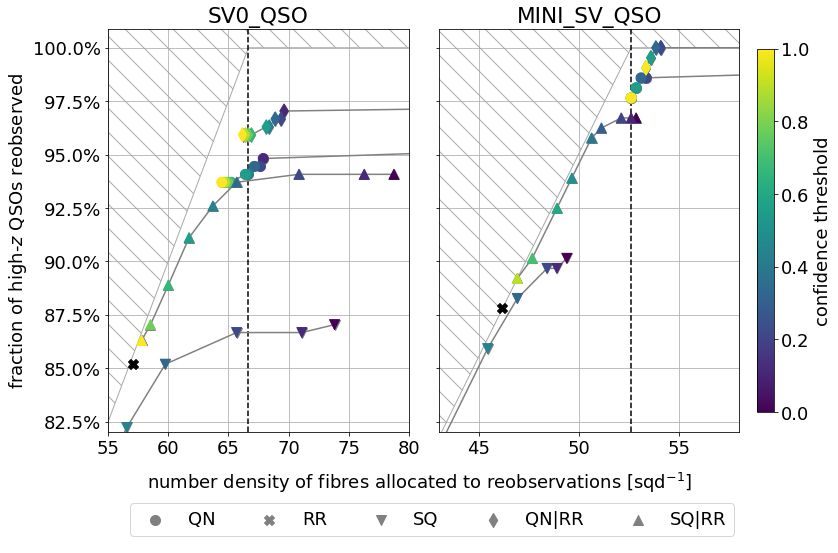

In [20]:
## Standard version of plot
filename = '../plots/classifier_performance_selecting_for_reobservation_tile68002_night20200315.pdf'
ymin = 0.82
strategies = stratdefs

# Construct a dictionary to average over exposures for each strategy.
strategies_to_plot = {}
for k, filt_name in enumerate(filters.keys()):
    filt_strategies_to_plot = {}
    for s in ['QN','SQ','RR','QN|RR','SQ|RR']:
        s_filt_strategies_to_plot = {}
        s_filt_strategies_to_plot['strategies'] = ['{} {} {}'.format(s,expid,filt_name) for expid in expids]
        s_filt_strategies_to_plot['marker'] = stratdefs[filt_name]['{} {} {}'.format(s,expids[0],filt_name)]['marker']
        s_filt_strategies_to_plot['color'] = stratdefs[filt_name]['{} {} {}'.format(s,expids[0],filt_name)]['color']
        filt_strategies_to_plot[s] = s_filt_strategies_to_plot
    strategies_to_plot[filt_name] = filt_strategies_to_plot
    
#print(strategies_to_plot)
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                               figsize=figsize,eff_area=eff_area,dv_max=dv_max,
                                               zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                               verbose=False,n_highz_desi=n_highz_desi,nydec=1,filters=filters,
                                               marker_size=100,strategies_to_plot=strategies_to_plot)

"""for k, filt_name in enumerate(filters.keys()):
    artists = []
    labels = []
    for i,expid in enumerate(expids):
        ## Add colour blobs to legend for exposure id
        c = np.zeros(3)
        c[(k-1)%3] = (i)/(len(expids)-1)
        artists += [axs[0,k].scatter([],[],color=c,s=100)]
        labels += ['{}'.format(expid)]
    axs[0,k].legend(artists,labels,ncol=1,loc=4)"""

plt.show()